# Leaf classification with Gradient Boosting

TODO: improve this introductory section!

This notebook presents a practical overview about shape analysis and classification. 

The dataset are available at [UCI repository](https://archive.ics.uci.edu/ml/datasets/leaf).

This notebook was splitted in the following sections:

1. Setup workspace
2. Load raw data
3. Image normalization
4. Feature extraction
5. Principal component analysis
6. Gradient boosting classifier
7. Results
8. Concluding remarks

## 1. Setup workspace

Set global options and import python packages:

In [1]:
#Some useful packages
import pathlib
import pandas
import random
import scipy
import numpy
import os
import re
import math

#To read image files
import scipy.ndimage as scimg
import scipy.spatial as spatial

#OpenCV image processing package
import cv2

#Plot tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as po

#Scikit learn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#Gradient Boosting Classifier
import xgboost as xgb

#IPython Display 
from IPython.display import display

#Global Settings
random.seed(5749)
%matplotlib inline
mpl.rcParams['figure.figsize'] = (14,7)
po.init_notebook_mode(connected=True)

/Users/dulpneto/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



## 2. Load the raw images

The raw images from the [UCI repository](https://archive.ics.uci.edu/ml/datasets/leaf) were added into the local folder: `./data/raw-images/`.

Here we scan all subdirectories and store each image in a numpy array:

In [2]:
#Raw data path
folder = "./data/raw-images/"

#Check subdirectories
subdirectories = list(map(str, [sb for sb in  pathlib.Path(folder).iterdir() if sb.is_dir()]))
subdirectories.sort()

#Load all images in each subdirectory
images = []
cat_id = 1
id = 1
for sb in subdirectories:
    filenames = os.listdir(sb)
    filenames = [fname for fname in filenames if re.match(".*.jpg", fname)]
    filenames.sort()
    classname = os.path.basename(sb).lower()
    for fname in filenames:
        images.append({
                "id": id,
                "species_name": classname,
                "image": scimg.imread(sb + "/" + fname)})
        id += 1
    cat_id += 1

#Store labels for each image id 
labeltable = pandas.DataFrame(images, columns = ["id", "species_name"])

### 2.1 Example Plot

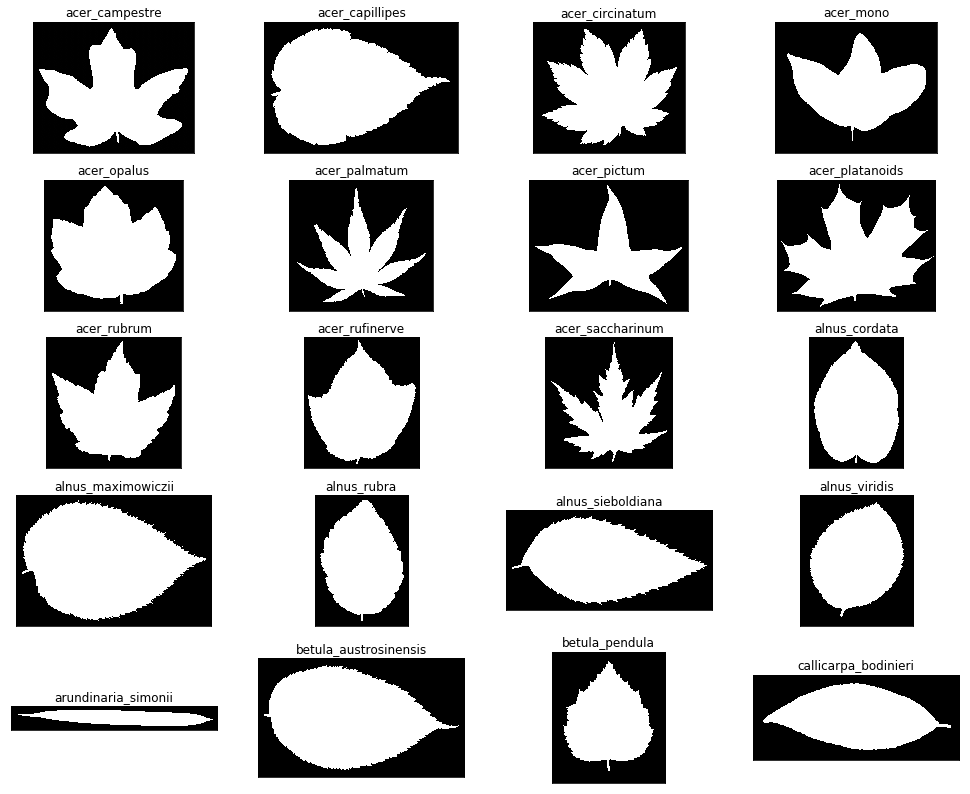

In [3]:
mpl.rcParams['figure.figsize'] = (17,14)
samples = list(range(0, 20*16, 16))

plt.figure()
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.title(images[samples[i]]["species_name"])
    fig = plt.imshow(images[samples[i]]["image"], cmap = "gray")
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

plt.show()
mpl.rcParams['figure.figsize'] = (14,7)

## 3. Image normalization and pre-processing

The raw images have different pixel sizes, which can be a problem for some features that are sensible to shifting.

In this section we insert all leaf images in a black background in such a way that all images have the same pixel size and the center of mass of each leaf matches the center of the global image.

### 3.1 Find a suitable image size

In [4]:
#Center of mass of each leaf
mass_centers = [tuple(map(int, scimg.measurements.center_of_mass(img["image"]))) for img in images]
#Shape of each raw image
im_shapes = [img["image"].shape for img in images]

#Find out a suitable image size to normalize images
max_height = numpy.array([2*max(im_shapes[i][0]-mass_centers[i][0], mass_centers[i][0]) for i in range(len(im_shapes))]).max()
max_width = numpy.array([2*max(im_shapes[i][1]-mass_centers[i][1], mass_centers[i][1]) for i in range(len(im_shapes))]).max()
max_width  = round(max_width+5, -1) + 1
max_height = round(max_height+5, -1) + 1

#Shape of normalized images
shape = (max_height, max_width)

#Center position of images
center = (int(max_height/2), int(max_width/2))

### 3.2 Save all images with the same size

In [5]:
#Destination folder of normalized images
folder = "./data/normalized-images/"
if not os.path.exists(folder):
    os.makedirs(folder)


#Save images after normalization
for idx, img in enumerate(images):
    norm_image = numpy.zeros(shape)
    img_center = scimg.measurements.center_of_mass(img["image"])
    img_center = tuple([int(round(c)) for c in img_center])
    x0 = center[0]-img_center[0]
    y0 = center[1]-img_center[1]
    x1 = x0 + img["image"].shape[0]
    y1 = y0 + img["image"].shape[1]
    norm_image[x0:x1, y0:y1] = img["image"]
    scipy.misc.imsave(folder + str(img["id"]).zfill(4) + "_" + img["species_name"] + ".jpg", norm_image)

#Delete images to free memory
del images

### 3.3 Example Plot

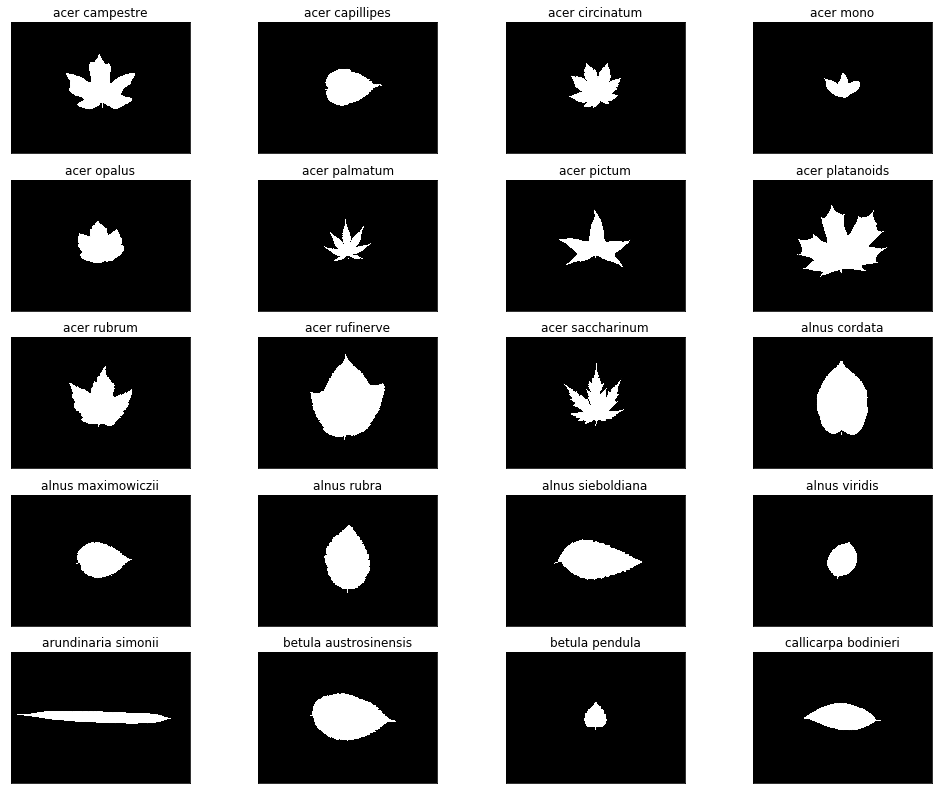

In [6]:
folder = "./data/normalized-images/"

filenames = os.listdir(folder)
filenames = numpy.array([fname for fname in filenames if re.match(".*.jpg", fname)])
filenames.sort()
samples = filenames[[i for i in range(0, 20*16, 16)]]

mpl.rcParams['figure.figsize'] = (17,14)
plt.figure()
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.title(samples[i][5:-4].replace("_", " "))
    fig = plt.imshow(cv2.cvtColor(scimg.imread(folder + samples[i]),cv2.COLOR_GRAY2RGB))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

plt.show()
mpl.rcParams['figure.figsize'] = (14,7)

## 4. Feature Engineering

### 4.1 Choosing features

#### 4.1.1 Area

The plot below shows two distinct leaf species: `acer_mono` (left) and `liriodendron_tulipifera` (right).

It's easy to see that the leaf area can be a good feature.

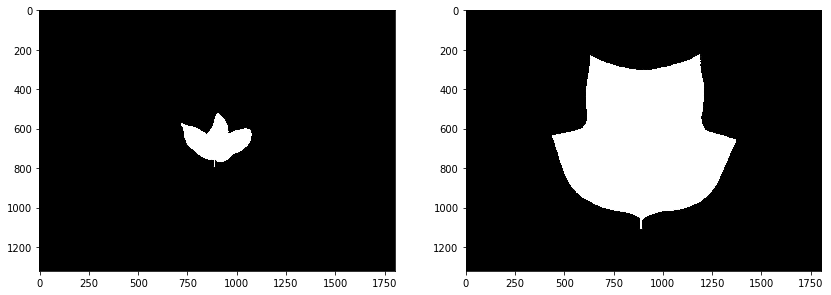

In [7]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(scimg.imread(folder + "0049_acer_mono.jpg"),cv2.COLOR_GRAY2RGB))
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(scimg.imread(folder + "0593_liriodendron_tulipifera.jpg"),cv2.COLOR_GRAY2RGB))
plt.show()

#### 4.1.2 Perimeter & Perimeter/Area


However, leaf species with similar area can have very different perimeter.

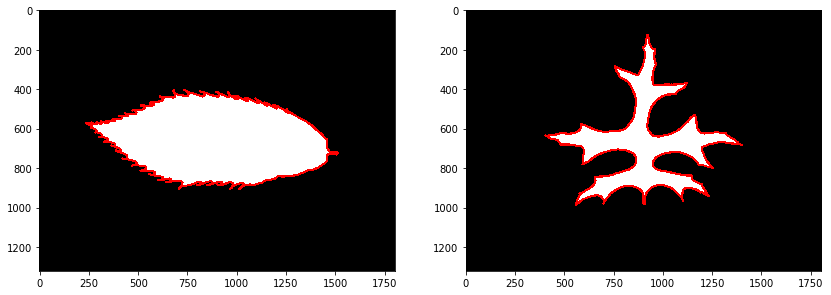

Area:
0173_castanea_sativa: 389177.5
0214_quercus_palustris: 199065.5
Perimeter:
0173_castanea_sativa: 5097.871601343155
0214_quercus_palustris: 6080.0179134607315


In [8]:
ret, im1 = cv2.threshold(scimg.imread(folder + "0336_castanea_sativa.jpg"), 127, 255, 0)
ret, im2 = cv2.threshold(scimg.imread(folder + "1166_quercus_palustris.jpg"), 127, 255, 0)

im, contours1, hierarchy = cv2.findContours(im1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
im, contours2, hierarchy = cv2.findContours(im2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contour1 = contours1[numpy.array(list(map(len, contours1))).argmax()]
contour2 = contours2[numpy.array(list(map(len, contours2))).argmax()]

im1 = cv2.cvtColor(im1, cv2.COLOR_GRAY2RGB)
im2 = cv2.cvtColor(im2, cv2.COLOR_GRAY2RGB)

im1 = cv2.drawContours(im1, contours1, 0, (255,0,0), 10)
im2 = cv2.drawContours(im2, contours2, 0, (255,0,0), 10)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(im1)
plt.subplot(1,2,2)
plt.imshow(im2)
plt.show()

print("Area:")
print("0173_castanea_sativa: " + str(cv2.contourArea(contour1)))
print("0214_quercus_palustris: " + str(cv2.contourArea(contour2)))
print("Perimeter:")
print("0173_castanea_sativa: " + str(cv2.arcLength(contour1,True)))
print("0214_quercus_palustris: " + str(cv2.arcLength(contour2,True)))

#### 4.1.3 Extent

Extent is the ratio of contour area to bounding rectangle area:

$Extent = \dfrac{Object Area}{Bounding Rectangle Area}$

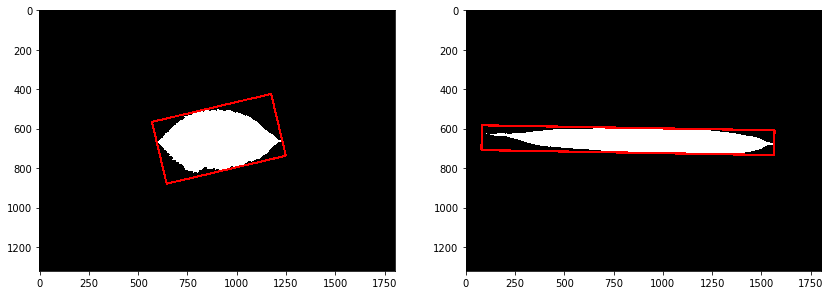

In [9]:
ret, im1 = cv2.threshold(scimg.imread(folder + "1209_quercus_pontica.jpg"), 127, 255, 0)
ret, im2 = cv2.threshold(scimg.imread(folder + "0262_arundinaria_simonii.jpg"), 127, 255, 0)

im, contours1, hierarchy = cv2.findContours(im1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
im, contours2, hierarchy = cv2.findContours(im2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contour1 = contours1[numpy.array(list(map(len, contours1))).argmax()]
contour2 = contours2[numpy.array(list(map(len, contours2))).argmax()]

rect1 = cv2.minAreaRect(contour1)
rect2 = cv2.minAreaRect(contour2)

box1 = numpy.int0(cv2.boxPoints(rect1))
box2 = numpy.int0(cv2.boxPoints(rect2))

im1 = cv2.cvtColor(im1, cv2.COLOR_GRAY2RGB)
im2 = cv2.cvtColor(im2, cv2.COLOR_GRAY2RGB)

im1 = cv2.drawContours(im1, [box1], 0, (255,0,0), 10)
im2 = cv2.drawContours(im2, [box2], 0, (255,0,0), 10)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(im1)
plt.subplot(1,2,2)
plt.imshow(im2)
plt.show()

#### 4.1.4 Slimness

Using the width and height from the minimum bounding rectangle, it is possible to define how elongated the image shape is.

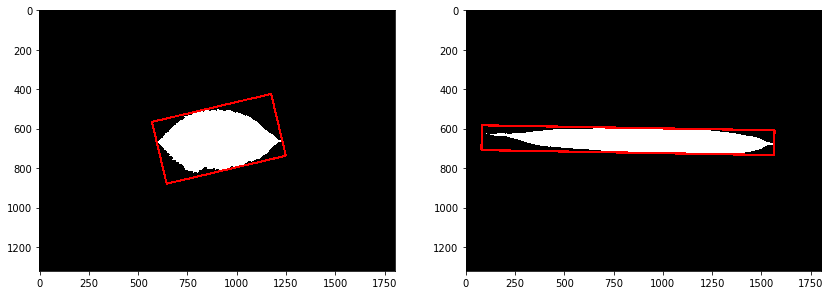

Slimness:
1209_quercus_pontica: 1.92611607842
0262_arundinaria_simonii: 11.7382933805


In [10]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(im1)
plt.subplot(1,2,2)
plt.imshow(im2)
plt.show()

d_box1_1 = spatial.distance.euclidean(box1[0],box1[1])
d_box1_2 = spatial.distance.euclidean(box1[1],box1[2])

d_box2_1 = spatial.distance.euclidean(box2[0],box2[1])
d_box2_2 = spatial.distance.euclidean(box2[1],box2[2])

print("Slimness:")
print("1209_quercus_pontica: " + str(max(d_box1_1, d_box1_2)/min(d_box1_1, d_box1_2)))
print("0262_arundinaria_simonii: " + str(max(d_box2_1, d_box2_2)/min(d_box2_1, d_box2_2)))

#### 4.1.5 Convex Hull area and perimiter ratios

With the convex hull it is possible to define relations between the perimeter and area of the image and the convex hull. With this it is possible to define relations based on the deformity of the image and the quantity of concave regions of the shape.

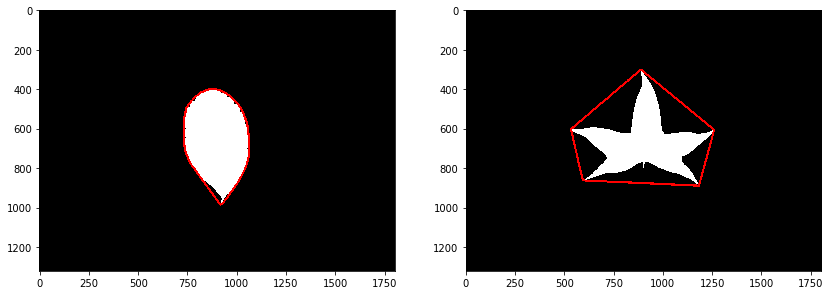

In [11]:
ret, im1 = cv2.threshold(scimg.imread(folder + "1480_sorbus_aria.jpg"), 127, 255, 0)
ret, im2 = cv2.threshold(scimg.imread(folder + "0097_acer_pictum.jpg"), 127, 255, 0)

im, contours1, hierarchy = cv2.findContours(im1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
im, contours2, hierarchy = cv2.findContours(im2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

contour1 = contours1[numpy.array(list(map(len, contours1))).argmax()]
contour2 = contours2[numpy.array(list(map(len, contours2))).argmax()]

convex_hull_1 = cv2.convexHull(contour1)
convex_hull_2 = cv2.convexHull(contour2)

im1 = cv2.cvtColor(im1, cv2.COLOR_GRAY2RGB)
im2 = cv2.cvtColor(im2, cv2.COLOR_GRAY2RGB)

im1 = cv2.drawContours(im1, [convex_hull_1], 0, (255,0,0), 10)
im2 = cv2.drawContours(im2, [convex_hull_2], 0, (255,0,0), 10)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(im1)
plt.subplot(1,2,2)
plt.imshow(im2)
plt.show()

#### 4.1.6 Solidity

Solidity is the ratio of contour area to its convex hull area:

$Solidity = \dfrac{Object Area}{Convex Hull Area}$

#### 4.1.7 Roundness

$Roundness = \dfrac{4 \times \pi \times Area}{(Perimeter)^2}$

#### 4.1.8 Equivalent Diameter

Equivalent Diameter is the diameter of the circle whose area is same as the area of the object:

$Equivalent\_Diameter = \sqrt{\dfrac{4 \times Contour\_Area}{\pi}}$

#### 4.1.9 Dispersion

Dispersion is the ratio between the largest and smallest distance from the centroid. With this feature is possible to define how irregular the image shape is.

$Dispersion = \dfrac{max(\sqrt{(x_i-\bar{x})^2+(y_i-\bar{y})^2}}{min(\sqrt{(x_i-\bar{x})^2+(y_i-\bar{y})^2}}$

### 4.2 Extract image features

In [12]:
#Path to normalized images
folder = "./data/normalized-images/"

#Scan all files
filenames = os.listdir(folder)
filenames = [fname for fname in filenames if re.match(".*.jpg", fname)]
filenames.sort()
filenames = filenames[0:(16*20)] #subset

#Extract features for each image
features = []
for file in filenames:
    img =  scimg.imread(folder + file)
    ret, thresh = cv2.threshold(img, 127, 255, 0)
    img2, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    contour = contours[numpy.array(list(map(len, contours))).argmax()]
    convex_hull = cv2.convexHull(contour)    
    rect = cv2.minAreaRect(contour)
    box = cv2.boxPoints(rect)
    d1 = spatial.distance.euclidean(box[0],box[1])
    d2 = spatial.distance.euclidean(box[1],box[2])
    img_center = scimg.measurements.center_of_mass(img)
    img_center = tuple([int(round(c)) for c in img_center])
    x0 = img_center[0]
    y0 = img_center[1]
        
    area = cv2.contourArea(contour)
    rect_area = d1*d2
    extent = float(area)/rect_area
    convex_hull_area = cv2.contourArea(convex_hull)
    convex_hull_perimeter = cv2.arcLength(convex_hull,True)
    solidity = area/convex_hull_area
    perimeter = cv2.arcLength(contour,True)
    hull_perimeter_ratio = perimeter/convex_hull_perimeter
    perimeter_area_ratio = perimeter/area
    slimness = max(d1, d2)/min(d1, d2)
    equi_diameter = numpy.sqrt(4*area/numpy.pi)
    roundness = 4*math.pi*area/perimeter*perimeter
    
    eucl_dist = numpy.zeros(len(contour))
    for index, p in enumerate(contour):
        eucl_dist[index] = scipy.spatial.distance.euclidean([x0,y0],p[0])
    dispersion = max(eucl_dist)/min(eucl_dist)
    contourdistvar = numpy.std(eucl_dist)
    
    features.append([
            int(file[:4]),
            area,
            rect_area,
            extent,
            convex_hull_area,
            solidity,
            perimeter,
            perimeter_area_ratio,
            slimness,
            equi_diameter,
            roundness,
            dispersion,
            contourdistvar,
            hull_perimeter_ratio
            ])

### 4.3 Build the dataset

In [13]:
#Feature set
dataset = pandas.DataFrame(features, 
                           columns=["id", "area", "rect_area", "extent", "convex_hull_area", 
                                    "solidity", "perimeter", "perimeter_area_ratio", "slimness",
                                    "equi_diameter", "roundness", "dispersion", "contourdistvar",
                                    "hull_perimeter_ratio"
                                   ])

#Add class label
dataset = pandas.merge(dataset, labeltable, how="left", on="id")

#Add class label id
target = [[i] * 16 for i in range(20)]
target = numpy.asarray(numpy.array(target)).reshape(-1)
dataset["class_id"] = target

#Save to '.csv' file
dataset.to_csv("dataset.csv")

## 5. Principal Component Analysis

TODO: explain why we should use PCA

### 5.1 Extract principal components

In [14]:
#Inputs and outputs
X = dataset.ix[:,1:-2]
y = dataset.ix[:,-2]

#Scale normalization
X_std = StandardScaler().fit_transform(X)

#Compute covariance matrix, eigenvalues and eigenvectors
cov_mat = numpy.cov(X_std.T)
eig_vals, eig_vecs = numpy.linalg.eig(cov_mat)

#Compute principal components (PCA)
eig_pairs = [(numpy.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
matrix_w = numpy.hstack(tuple([ep[1].reshape(len(X.columns),1) for ep in eig_pairs]))
Y = X_std.dot(matrix_w)

/Users/dulpneto/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



### 5.2 Variance of principal components

In [15]:
#Compute self and cumulative variance of each PCA component
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = numpy.cumsum(var_exp)

#Plot variance of each component
trace1 = go.Bar(
        x=['PC %s' %i for i in range(1,Y.shape[1])],
        y=var_exp,
        showlegend=False)

trace2 = go.Scatter(
        x=['PC %s' %i for i in range(1,Y.shape[1])], 
        y=cum_var_exp,
        name='cumulative explained variance')

data = go.Data([trace1, trace2])

layout = go.Layout(
    title='Explained variance by different principal components',  
    hovermode="closest",
    yaxis=go.YAxis(title='Explained variance in percent'))

fig = go.Figure(data=data, layout=layout)
po.iplot(fig)

From the above plot we can see that 83% of the dataset variance can be retrieved

### 5.3 Scatter plot visualization (2 PCs)

In [16]:
traces = []

for name in numpy.unique(y):
    trace = go.Scatter(
        x=Y[y==name,0],
        y=Y[y==name,1],
        mode="markers",
        name=name,
        marker=go.Marker(
            size=12,
            line=go.Line(
                color="rgba(217, 217, 217, 0.14)",
                width=0.5),
            opacity=0.7))
    traces.append(trace)


data = go.Data(traces)

layout = go.Layout(
    title= "Leaf Species",
    hovermode= "closest",
    xaxis= dict(
        title= "Principal Component 1",
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= "Principal Component 2",
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)

fig = go.Figure(data=data, layout=layout)
po.iplot(fig)

### 5.4 Scatter plot visualization (3 PCs)

From the previous plot we can see that with just 2 principal components it can be very diffucult to classify some leaf species. 

Let's try to visualize the first 3 principal components and see what we can get:

In [17]:
traces = []

for name in numpy.unique(y):
    trace = go.Scatter3d(
        x=Y[y==name,0],
        y=Y[y==name,1],
        z=Y[y==name,2],
        mode="markers",
        name=name,
        marker=go.Marker(
            size=12,
            line=go.Line(
                color="rgba(217, 217, 217, 0.14)",
                width=0.5),
            opacity=0.8))
    traces.append(trace)
   
layout = go.Layout(
    title= "Leaf Species",
    hovermode= "closest",
    xaxis= dict(
        title= "Principal Component 1",
        ticklen= 5,
        zeroline= False,
        gridwidth= 2,
    ),
    yaxis=dict(
        title= "Principal Component 2",
        ticklen= 5,
        gridwidth= 2,
    ),
    showlegend= False
)

fig = go.Figure(data=go.Data(traces), layout=layout)
po.iplot(fig)

## 6. Gradient Boosting Classifier

### 6.1 Split the data into train and test set

In [18]:
#Split train and test set
seed = ["test"] * 6 + ["train"] * 10

rowset = []
for _ in range(20):
    random.shuffle(seed)
    rowset += seed

rowset = numpy.array(rowset)

trainset = dataset[rowset == "train"]
traindata = trainset.iloc[:,1:-2]
traintarget = trainset.iloc[:, -1]

testset = dataset[rowset == "test"]
testdata = testset.iloc[:,1:-2]
testtarget = testset.iloc[:, -1]

### 6.2 Fit Gradient Boosting Model

In [19]:
dtrain = xgb.DMatrix(traindata, label=traintarget)
dtest = xgb.DMatrix(testdata)

param = {
    'max_depth': 5,
    'eta': 0.01,
    'silent': 1,
    'objective': 'multi:softprob',
    'num_class': 20}

num_round = 300  # the number of training iterations

xgbmodel = xgb.train(param, dtrain, num_round)

preds = xgbmodel.predict(dtest)
preds = [p.argmax() for p in preds]

## 7. Results

### 7.1 Accuracy

In [20]:
accuracy_score(testtarget, preds)

0.90000000000000002

### 7.2 Confusion Matrix

In [21]:
cm = confusion_matrix(testtarget, preds)
class_id = [str(i).zfill(2) for i in range(1, 21)]

cmdf = pandas.DataFrame(cm)
cmdf.columns = [ "[" + ci + "]" for ci in class_id]
cmdf.index = [name + " [" + class_id[idx] + "]" for idx, name in enumerate(dataset["species_name"].unique())]
display(cmdf)

,[01],[02],[03],[04],[05],[06],[07],[08],[09],[10],[11],[12],[13],[14],[15],[16],[17],[18],[19],[20]
acer_campestre [01],2,1,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0
acer_capillipes [02],0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
acer_circinatum [03],0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
acer_mono [04],0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
acer_opalus [05],0,1,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
acer_palmatum [06],0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0
acer_pictum [07],0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0
acer_platanoids [08],0,0,0,0,0,0,0,5,1,0,0,0,0,0,0,0,0,0,0,0
acer_rubrum [09],1,0,0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,0
acer_rufinerve [10],0,0,0,0,0,0,0,0,1,5,0,0,0,0,0,0,0,0,0,0


### 7.3 Feature Importance

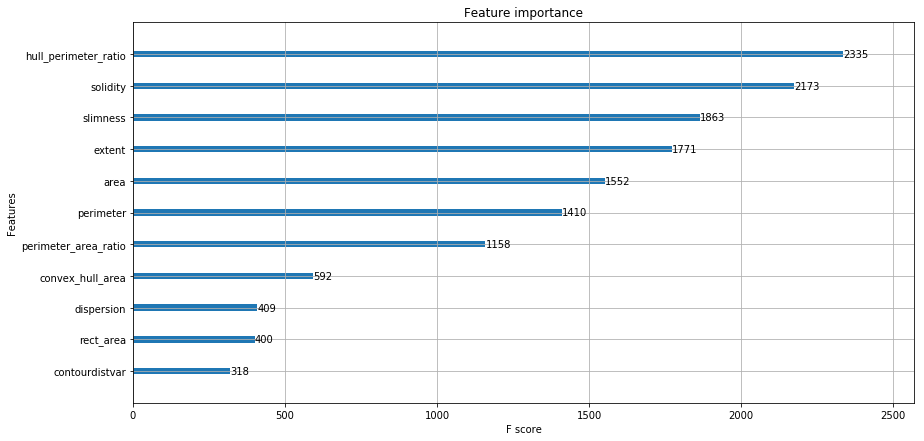

In [22]:
xgb.plot_importance(xgbmodel)

## 8. Concluding remarks

TODO: Present some conclusions about this analysis